In [ ]:
import sys
sys.path.append("BCNN-SCP")

import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from src.main import LightningModule
from src.models.kernels import RBFKernel, MaternKernel, RQKernel

# Load checkpoint
path = "checkpoints/BCNN a=0.01 l=3.0 k=RBF/last.ckpt"
ckpt = torch.load(path, weights_only=False, map_location="cpu")
config = ckpt["hyper_parameters"]["config"]
weights = ckpt["state_dict"]

# Load model
model = LightningModule(config)
model.load_state_dict(weights)
model.eval()

# Load dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((config["data"]["normalize_mean"],), (config["data"]["normalize_std"],))
])
dataset = datasets.MNIST(root='data', train=False, transform=transform, download=False)

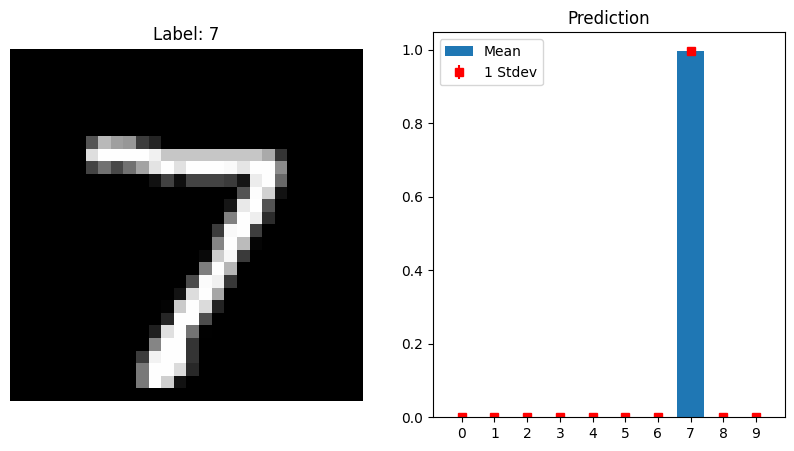

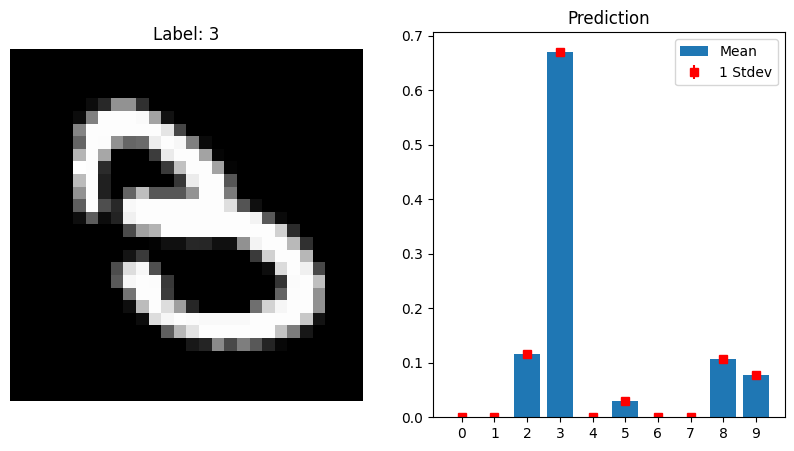

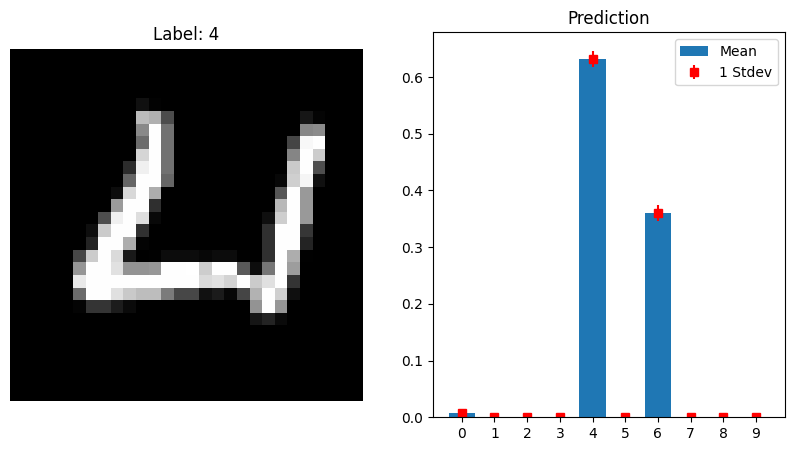

In [26]:
# Helper function to visualize prediction
def visualize_prediction(index):
    # Fix seed for reproducibility
    torch.manual_seed(42)

    # Get image and label
    image, label = dataset[index]

    # Get prediction
    probs = model.predict(image) # (n_samples, n_classes)

    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Visualize image
    # Denormalize for visualization
    image = image * config["data"]["normalize_std"] + config["data"]["normalize_mean"]
    image = image[0] # Grayscale image
    axs[0].imshow(image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Label: {label}")

    # Visualize prediction
    probs_mean = probs.mean(dim=0)
    probs_std = probs.std(dim=0)
    axs[1].bar(range(10), probs_mean, label="Mean")
    axs[1].errorbar(range(10), probs_mean, yerr=probs_std, fmt='rs', label="1 Stdev")
    axs[1].legend()
    axs[1].set_xticks(range(10))
    axs[1].set_title("Prediction")

    return fig

for i in [0, 18, 33]:
    fig = visualize_prediction(i)
    fig.savefig(f"figures/prediction_{i}.pdf")

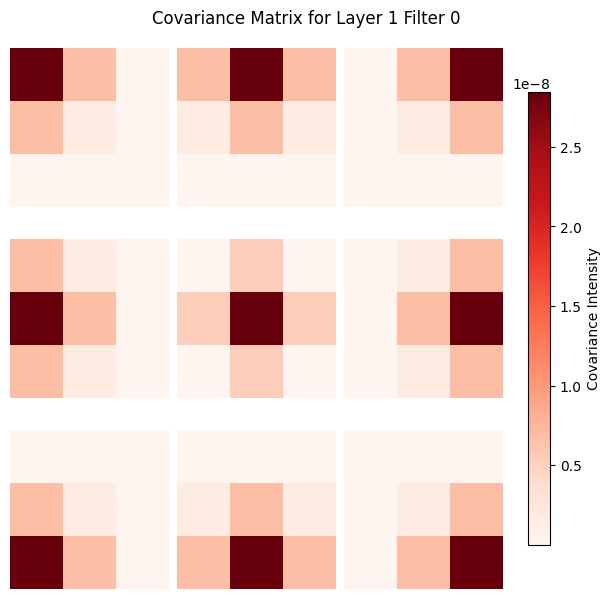

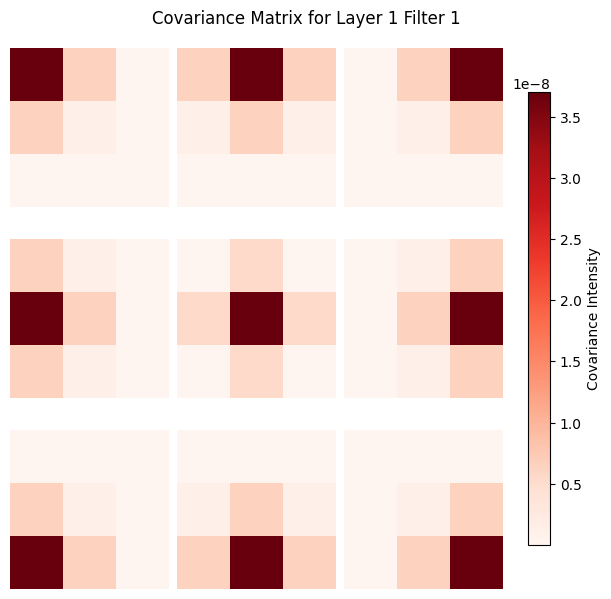

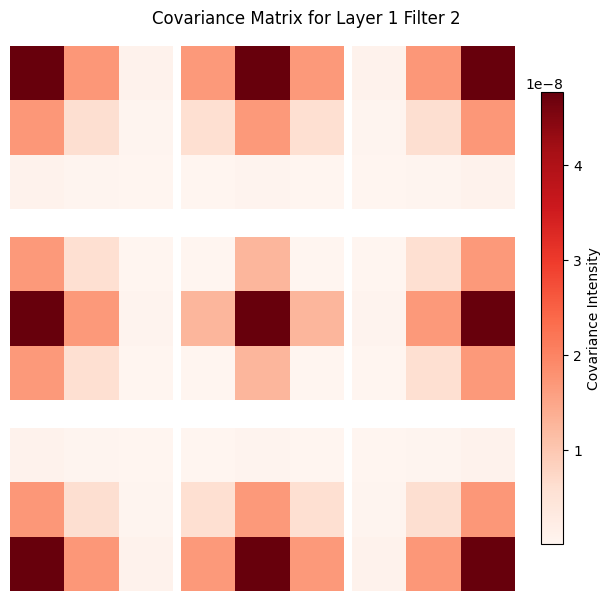

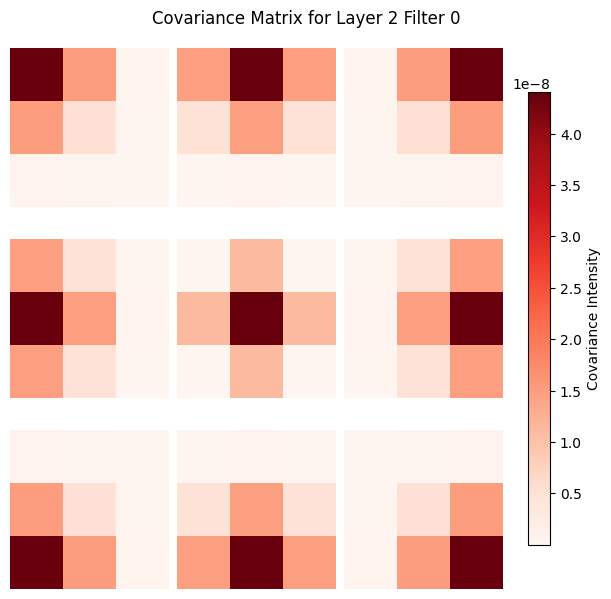

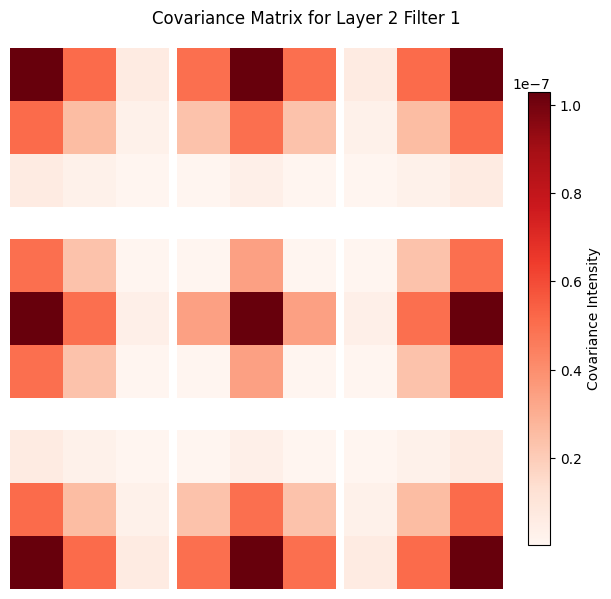

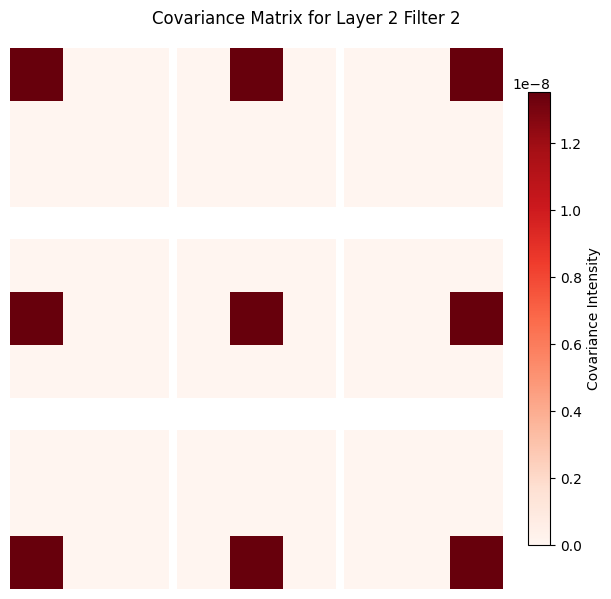

In [27]:
def visualize_covariance(layer, filter):
    # Get weight
    a = weights[f"model.conv{layer}.a"][filter]
    l = weights[f"model.conv{layer}.l"][filter]

    # Get kernel
    kernel = config["model"]["kernel"]["name"]
    if kernel == "RBF":
        kernel = RBFKernel(a, l)
    elif kernel == "Matern":
        kernel = MaternKernel(a, l)
    elif kernel == "RQ":
        kernel = RQKernel(a, l)

    # Get covariance
    h = w = config["model"][f"filter_size_conv{layer}"]
    covar = kernel(h, w)

    # Reshape the covariance matrices for visualization
    cov_matrices_layer1 = [covar[i].view(h,w) for i in range(h*w)]

    # Plot the spatial covariance matrices
    fig, axes = plt.subplots(3, 3, figsize=(6, 6), constrained_layout=True)

    for idx, ax in enumerate(axes.flat):  # Flatten axes for simpler indexing
        im = ax.imshow(cov_matrices_layer1[idx], cmap="Reds")
        ax.axis("off")  # Turn off ticks and labels for cleaner visuals

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im, ax=axes, orientation="vertical", shrink=0.8, aspect=20, pad=0.02)
    cbar.set_label("Covariance Intensity", fontsize=10)

    # Display the plot
    fig.suptitle(f"Covariance Matrix for Layer {layer} Filter {filter}", fontsize=12)
    return fig

for layer in range(1, 3):
    for filter in range(3):
        fig = visualize_covariance(layer, filter)
        fig.savefig(f"figures/covariance_{layer}_{filter}.pdf")